In [1]:
from datasets import load_dataset
import torch
from torch import nn, optim, tensor
from torch.utils.data import DataLoader, default_collate
import matplotlib.pyplot as plt
import matplotlib as mpl
import torchvision.transforms.functional as TF
from miniai.datasets import *
from operator import itemgetter
from miniai.conv import to_device
from torch.nn.functional import cross_entropy
from torch.nn.functional import mse_loss

import torch.nn.functional as F

In [2]:
torch.manual_seed(42)
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['image.cmap']='gray'

In [3]:
ds = load_dataset ('fashion_mnist')
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [4]:
def transformi(b):
    b['image'] = [TF.pil_to_tensor(o).float() for o in b['image']]
    return b

In [5]:
ds_trans = ds.with_transform(transformi)

In [6]:
x,y = ds_trans['train'].features
x,y 

('image', 'label')

In [7]:
def collate_dic(ds):
    get = itemgetter(x,y)
    def get_batch(b): return get(default_collate(b))
    return get_batch

cd = collate_dic(ds_trans)

In [8]:
def collate_func(b):
    return to_device(cd(b))

In [9]:
bs = 250

In [10]:
def dls_dic(ds):
    return { k: DataLoader(v, bs, collate_fn=collate_func) for k,v in ds.items()}


dls = dls_dic(ds_trans)
dl_train = dls['train']
dl_valid = dls['test']

In [11]:
xb, yb = next(iter(dl_train))
xb.shape, yb

(torch.Size([250, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4, 3, 1, 4, 8, 4, 3, 0, 2, 4, 4, 5, 3, 6, 6, 0, 8, 5, 2, 1, 6, 6, 7, 9, 5,
         9, 2, 7, 3, 0, 3, 3, 3, 7, 2, 2, 6, 6, 8, 3, 3, 5, 0, 5, 5, 0, 2, 0, 0, 4, 1, 3, 1, 6, 3, 1, 4, 4, 6, 1, 9, 1, 3, 5, 7, 9, 7, 1, 7,
         9, 9, 9, 3, 2, 9, 3, 6, 4, 1, 1, 8, 8, 0, 1, 1, 6, 8, 1, 9, 7, 8, 8, 9, 6, 6, 3, 1, 5, 4, 6, 7, 5, 5, 9, 2, 2, 2, 7, 6, 4, 1, 8, 7,
         7, 5, 4, 2, 9, 1, 7, 4, 6, 9, 7, 1, 8, 7, 1, 2, 8, 0, 9, 1, 8, 7, 0, 5, 8, 6, 7, 2, 0, 8, 7, 1, 6, 2, 1, 9, 6, 0, 1, 0, 5, 5, 1, 7,
         0, 5, 8, 4, 0, 4, 0, 6, 6, 4, 0, 0, 4, 7, 3, 0, 5, 8, 4, 1, 1, 2, 9, 2, 8, 5, 0, 6, 3, 4, 6, 0, 9, 1, 7, 3, 8, 5, 8, 3, 8, 5, 2, 0,
         8, 7, 0, 3, 5, 0, 6, 5, 2, 7, 5, 2, 6, 8, 2, 6, 8, 0, 4, 4, 4, 4, 4, 1, 5, 6, 5, 3, 3, 7], device='cuda:0'))

In [12]:
featy = ds['train'].features['label']
featy.names

['T - shirt / top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [13]:
ig_title = itemgetter(*yb[:8])
title = ig_title(featy.names)

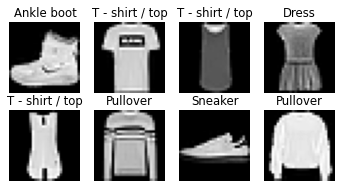

In [14]:
mpl.rcParams['figure.dpi'] = 70
show_images(xb[:8], imsize=1.5, titles=title)

In [15]:
def conv(n_in,n_out,ks=3, act=True ):
    conv2d = nn.Conv2d(n_in, n_out, kernel_size=ks,stride=2, padding=ks//2)
    if act: return nn.Sequential(conv2d,nn.ReLU())   # check how to do it with append
    return conv2d

In [16]:
"""model = nn.Sequential(
    conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,16),           #2x2
    conv(16,10, act=False), #1x1
    nn.Flatten(),
).cuda()

def accuracy(out,targ):
    return (out.argmax(dim=-1)==targ).float().mean().item()

accuracy(model(xb),yb)

epochs = 3
opt= optim.SGD(model.parameters(),lr=0.5)
loss_func = cross_entropy

for epoch in range(epochs):
    accuracy_tot = 0.
    loss_tot = 0.
    count = 0
    
    model.train()
    for xb, yb in dl_train:    
        loss = loss_func(model(xb),yb)
        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        for xb, yb in dl_valid:
            preds = model(xb)
            n = len(xb)
            count += n
            accuracy_tot += accuracy(preds,yb)*n
            loss_tot +=  loss_func(preds,yb).item()*n
    print(f'loss: {loss_tot/count:.2f}, accuracy: {accuracy_tot/count:.2f}') """  

"model = nn.Sequential(\n    conv(1 ,4),            #14x14\n    conv(4 ,8),            #7x7\n    conv(8 ,16),           #4x4\n    conv(16,16),           #2x2\n    conv(16,10, act=False), #1x1\n    nn.Flatten(),\n).cuda()\n\ndef accuracy(out,targ):\n    return (out.argmax(dim=-1)==targ).float().mean().item()\n\naccuracy(model(xb),yb)\n\nepochs = 3\nopt= optim.SGD(model.parameters(),lr=0.5)\nloss_func = cross_entropy\n\nfor epoch in range(epochs):\n    accuracy_tot = 0.\n    loss_tot = 0.\n    count = 0\n    \n    model.train()\n    for xb, yb in dl_train:    \n        loss = loss_func(model(xb),yb)\n        loss.backward()\n        opt.step()\n        opt.zero_grad()\n\n    model.eval()\n    with torch.no_grad():\n        for xb, yb in dl_valid:\n            preds = model(xb)\n            n = len(xb)\n            count += n\n            accuracy_tot += accuracy(preds,yb)*n\n            loss_tot +=  loss_func(preds,yb).item()*n\n    print(f'loss: {loss_tot/count:.2f}, accuracy: {accuracy

In [17]:
def deconv(n_in, n_out, ks=3, act=True):
    layers = [nn.UpsamplingNearest2d(scale_factor=2), nn.Conv2d(n_in, n_out, ks, stride=1, padding = ks//2)]
    if act: layers.append(nn.ReLU())
    return nn.Sequential(*layers)

In [18]:
ae = nn.Sequential(   #28x28
    nn.ZeroPad2d(2),  #32x32
    conv(1,2),        #16x16
    conv(2,4),        #8x8
    conv(4,8),        #4x4
    deconv(8,4),      #8x8
    deconv(4,2),      #16x16
    deconv(2,1, act=False), #32x32
    nn.ZeroPad2d(-2), #28x28
    nn.Sigmoid()
).cuda()

In [19]:
epochs = 5
loss_func = mse_loss
opt= optim.SGD(ae.parameters(),lr=0.1)

In [20]:
for epoch in range(epochs):
    loss_tot = 0.
    count = 0
    
    ae.train()
    for xb, _ in dl_train:    
        loss = loss_func(ae(xb),xb)
        loss.backward()
        opt.step()
        opt.zero_grad()

    ae.eval()
    with torch.no_grad():
        for xb, _ in dl_valid:
            preds = ae(xb)
            n = len(xb)
            count += n
            loss_tot +=  loss_func(preds,xb).item()*n
    print(f'loss: {loss_tot/count:.3f}', count)
    

/home/metao/fastai2023/part2/.conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995026/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


loss: 13282.329 10000
loss: 13282.329 10000
loss: 13282.329 10000
loss: 13282.329 10000
loss: 13282.329 10000


In [21]:
p = ae(xb)

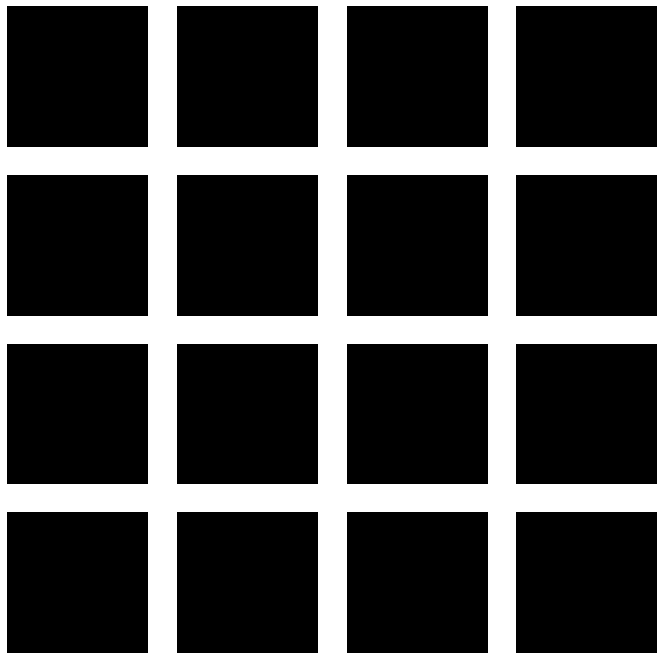

In [22]:
show_images(p[:16].data.cpu())